# **Система рекомендаций по фильмам**

### Что такое система рекомендаций?

Рекомендательные системы - это программы, которые, опираясь на алгоритмы и данные о пользователях, предсказывают, какие объекты (фильмы, книги, музыка, новости) могут быть для них наиболее интересными и релевантными. Рекомендательная система обрабатывает обширные объемы данных, отбирая наиболее значимую информацию на основе пользовательских предпочтений и других факторов. 
Проект нацелен на создание системы рекомендаций фильмов с использованием данных MovieLens для предоставления пользователю наиболее интересных кинематографических рекомендаций.

В данном проекте применяется метод контентной рекомендации, который основывается на анализе характеристик самих фильмов и предыдущих оценках, выставленных пользователями. Этот подход не зависит от действий других пользователей и сфокусирован на особенностях контента для предложения наиболее релевантных фильмов. Таким образом, система учитывает как предпочтения пользователя, так и особенности фильмов, чтобы сделать рекомендации более точными и персонализированными. Предполагается, что новых пользователей в систему не поступает, и рекомендации строятся на тех пользователей, которые уже имели активность в системе.

#### 1. Информация о предоставленных данных 


**Контекст:**

Наборы данных содержат информацию о рейтингах и тегах, добавленных пользователями к фильмам на платформе рекомендаций фильмов MovieLens. Набор данных MovieLens охватывает широкий спектр фильмов разных жанров, периодов времени и уровней популярности за период с 9 января 1995 года по 21 ноября 2019 года. Набор данных был сгенерирован 17 октября 2016 года. Пользователи были случайным образом выбраны для включения в данные, и все они оценили не менее 20 фильмов. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Информация о фильмах содержится в файле "movies.csv". Каждая строка этого файла после строки заголовка представляет идентификатор фильма, его название и жанры. Названия фильмов включают год выпуска в скобках. Жанры представляют собой список, разделенный вертикальными чертами. 

In [3]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Все рейтинги содержатся в файле "ratings.csv". Каждая строка этого файла после строки заголовка представляет одну оценку одного фильма одним пользователем. 
Строки в этом файле сначала упорядочены по идентификатору пользователя, а затем внутри пользователя по идентификатору фильма. 
Рейтинги выставляются по 5-звездочной шкале с шагом в ползвезды (0,5 звезды – 5,0 звезды). 
Временные метки представлены в виде количества секунд, прошедших с полуночи по всемирному координированному времени (UTC) 1 января 1970 года. Они отражают момент времени, когда пользователь поставил оценку фильму, но не обязательно совпадают с моментом просмотра фильма.

In [4]:
movies.shape, ratings.shape

((62423, 3), (25000095, 4))

#### 2. Работа с данными

**Набор данных "movie.csv":**

In [5]:
df_genres = movies['genres'].str.get_dummies(sep='|')

movies_nw = pd.concat([movies, df_genres], axis=1)
movies_nw = movies_nw.drop(['(no genres listed)', 'genres'], axis=1)

Жанры фильмов представлены в виде бинарных признаков в таблице, где 1 означает наличие определенного жанра, а 0 - его отсутствие.

In [6]:
movies_nw['release_year'] = movies_nw['title'].str.extract(r'\((\d{4})\)')
movies_nw['title'] = movies_nw['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

movies_nw

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,1,Toy Story,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1995
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,209157,We,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2018
62419,209159,Window of the Soul,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2001
62420,209163,Bad Poems,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,2018
62421,209169,A Girl Thing,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2001


Добавлен новый признак "Год производства фильма", извлеченный из названия фильмов.

In [7]:
movies_nw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieId       62423 non-null  int64 
 1   title         62423 non-null  object
 2   Action        62423 non-null  int64 
 3   Adventure     62423 non-null  int64 
 4   Animation     62423 non-null  int64 
 5   Children      62423 non-null  int64 
 6   Comedy        62423 non-null  int64 
 7   Crime         62423 non-null  int64 
 8   Documentary   62423 non-null  int64 
 9   Drama         62423 non-null  int64 
 10  Fantasy       62423 non-null  int64 
 11  Film-Noir     62423 non-null  int64 
 12  Horror        62423 non-null  int64 
 13  IMAX          62423 non-null  int64 
 14  Musical       62423 non-null  int64 
 15  Mystery       62423 non-null  int64 
 16  Romance       62423 non-null  int64 
 17  Sci-Fi        62423 non-null  int64 
 18  Thriller      62423 non-null  int64 
 19  War 

In [8]:
movies_nw.isna().sum()

movieId           0
title             0
Action            0
Adventure         0
Animation         0
Children          0
Comedy            0
Crime             0
Documentary       0
Drama             0
Fantasy           0
Film-Noir         0
Horror            0
IMAX              0
Musical           0
Mystery           0
Romance           0
Sci-Fi            0
Thriller          0
War               0
Western           0
release_year    410
dtype: int64

In [9]:
movies_nw['release_year'].isna().sum() / len(movies_nw)

0.0065680918892075035

In [10]:
movies_nw = movies_nw.dropna(subset='release_year')

In [11]:
movies_nw['release_year'] = movies_nw['release_year'].astype('int')

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_11720\4116751962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_nw['release_year'] = movies_nw['release_year'].astype('int')


Для столбца, отражающего год производства фильма, был изменен тип данных. Пропущенные значения признака "release_year" составляют менее 10% от общего числа, поэтому они были удалены.

**Набор данных "rating.csv":**

In [12]:
import datetime

In [13]:
ratings['timestamp'] = ratings['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))

Тип данных в столбце "timestamp" таблицы рейтингов был изменен на дату.

In [14]:
ratings['rating_year'] = ratings['timestamp'].dt.year

Добавлен новый признак, который отражает год проставления оценки.

In [15]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   userId       int64         
 1   movieId      int64         
 2   rating       float64       
 3   timestamp    datetime64[ns]
 4   rating_year  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 953.7 MB


In [16]:
ratings.isna().sum()

userId         0
movieId        0
rating         0
timestamp      0
rating_year    0
dtype: int64

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='rating_year', ylabel='userId'>

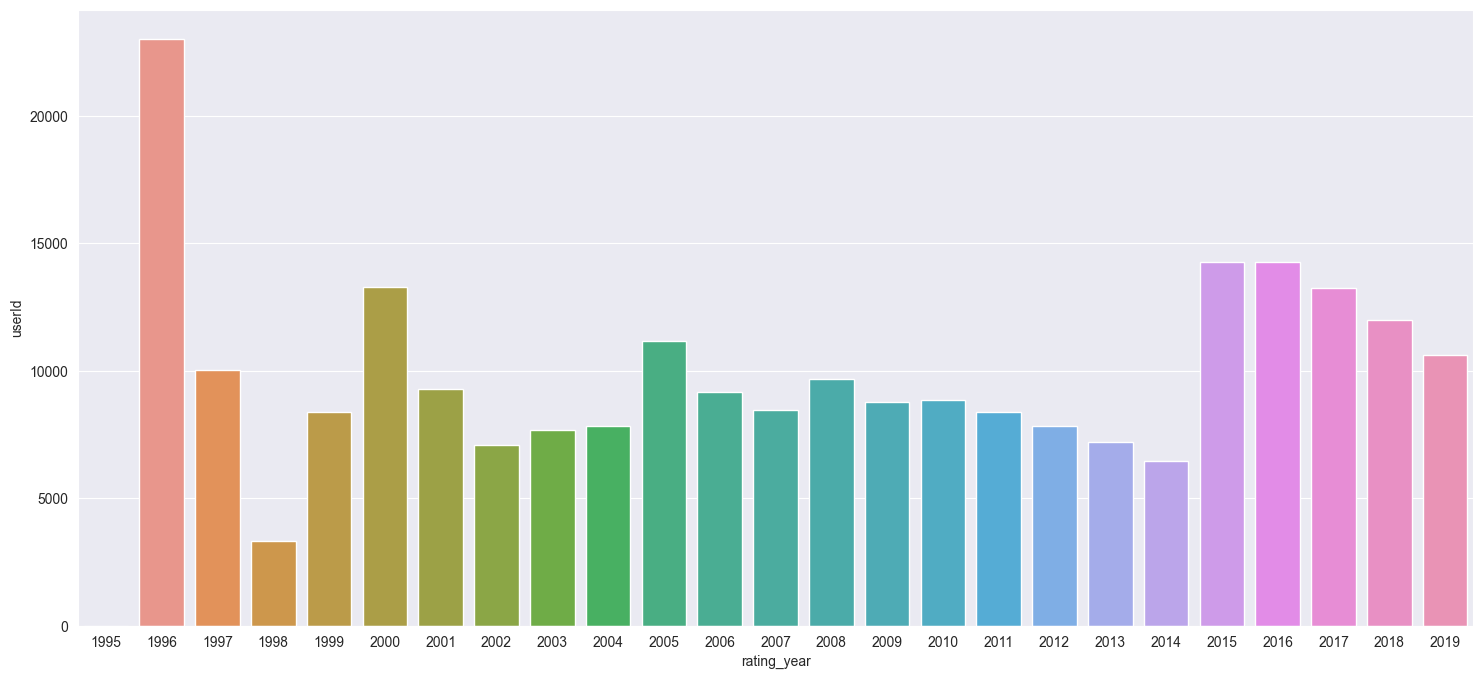

In [18]:
users_by_year = ratings.groupby(ratings['rating_year'])['userId'].nunique().reset_index()

plt.figure(figsize=(18, 8))
sns.barplot(data=users_by_year, x='rating_year', y='userId')

Построен график, отображающий количество пользователей по годам.

<Axes: xlabel='rating_year', ylabel='0'>

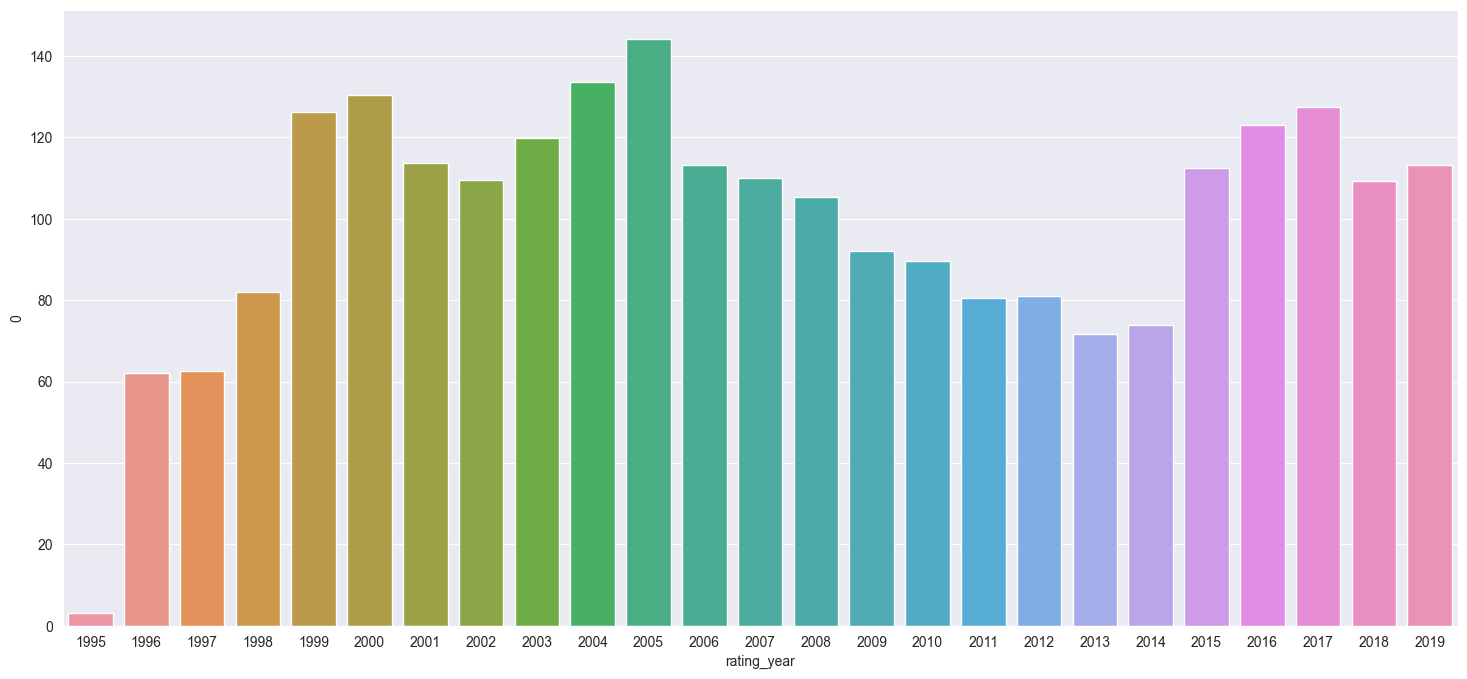

In [19]:
rating_by_year = ratings.groupby(ratings['rating_year'])['rating'].count() / ratings.groupby(ratings['rating_year'])['userId'].nunique()
rating_by_year = rating_by_year.reset_index()
plt.figure(figsize=(18, 8))
sns.barplot(rating_by_year, x='rating_year', y = 0)

Построен график, отражающий количество оценок в среднем на пользователя по годам.

Для дальнейшего анализа выбираем только данные, начиная с 2000 года, так как на графиках видно, что именно с этого времени данные становятся более значимыми и репрезентативными.

In [20]:
ratings['rating_year'].max()

2019

In [21]:
ratings = ratings[ratings['timestamp'].dt.year >= 2000]
ratings.shape

(21613474, 5)

Количество записей в таблице рейтингов было сокращено, учитывая активность пользователей за последние 19 лет с момента максимального года в таблице. Это сделано с целью сокращения объема данных и увеличения скорости обучения моделей. Учитывая, что вкусы и предпочтения пользователей могут измениться со временем, предполагается, что рекомендации фильмов будут более актуальными для тех пользователей, которые проявляли активность в последние 20 лет.

In [22]:
ratings.shape[0] / ratings['userId'].nunique()

174.51331449333873

In [23]:
def user_ratings_by_time(group):
    if len(group) >= 60:
        group = group.sort_values('timestamp', ascending=False)
        max_year = group['timestamp'].max().year
        max_year_data = group[group['timestamp'].dt.year == max_year].head(15)
        next_year_data = group[group['timestamp'].dt.year != max_year].head(45)
        result = pd.concat([max_year_data, next_year_data], ignore_index=True)
        return result

Для обучения модели используется функция, которая агрегирует данные, начиная с момента последней оценки пользователя, исключая "устаревшие" оценки. Количество записей на каждого пользователя сокращено в 3,5 раза для уменьшения объема данных и повышения эффективности модели. В набор данных включены только пользователи с более чем 60 записями для обеспечения достаточного количества информации для обучения модели и выявления различных зависимостей.

In [24]:
ratings_by_time = ratings.groupby('userId').apply(user_ratings_by_time)
ratings_by_time = ratings_by_time.reset_index(drop=True)

In [25]:
data = ratings_by_time.merge(movies_nw, on='movieId', how='left')

data

,userId,movieId,rating,timestamp,rating_year,title,Action,Adventure,Animation,Children,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,1,7361,5.0,2006-05-17 18:34:15,2006,Eternal Sunshine of the Spotless Mind,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2004.0
1,1,296,5.0,2006-05-17 18:34:04,2006,Pulp Fiction,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1994.0
2,1,7318,2.0,2006-05-17 18:30:50,2006,"Passion of the Christ, The",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004.0
3,1,5684,2.0,2006-05-17 18:29:57,2006,Naqoyqatsi,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2002.0
4,1,27193,3.0,2006-05-17 18:29:34,2006,Taxi 2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065724,162541,1617,4.5,2009-04-29 00:19:22,2009,L.A. Confidential,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1997.0
2065725,162541,29,5.0,2009-04-29 00:19:00,2009,"City of Lost Children, The (Cité des enfants p...",0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1995.0
2065726,162541,1197,4.5,2009-04-29 00:18:54,2009,"Princess Bride, The",1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1987.0
2065727,162541,296,3.5,2009-04-29 00:18:30,2009,Pulp Fiction,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1994.0


In [26]:
data.shape

(2065729, 26)

In [27]:
data.duplicated().sum()

0

In [28]:
data.isna().sum()

userId             0
movieId            0
rating             0
timestamp          0
rating_year        0
title           2826
Action          2826
Adventure       2826
Animation       2826
Children        2826
Comedy          2826
Crime           2826
Documentary     2826
Drama           2826
Fantasy         2826
Film-Noir       2826
Horror          2826
IMAX            2826
Musical         2826
Mystery         2826
Romance         2826
Sci-Fi          2826
Thriller        2826
War             2826
Western         2826
release_year    2826
dtype: int64

In [29]:
data['title'].isna().sum() / data.shape[0]

0.0013680400478475153

In [30]:
col_to_drop = [
    'title', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'release_year'
]
data = data.dropna(subset=col_to_drop)

Пропуски в колонках удалены, поскольку их количество невелико по сравнению с общим объемом данных в таблице.

In [31]:
data['time_since_prod'] = data['rating_year'] - data['release_year']

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_11720\3792620036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_since_prod'] = data['rating_year'] - data['release_year']


Добавлен новый признак, который отображает количество времени, прошедшее с даты выпуска фильма до даты оценки.

#### 3. Разведочный анализ данных

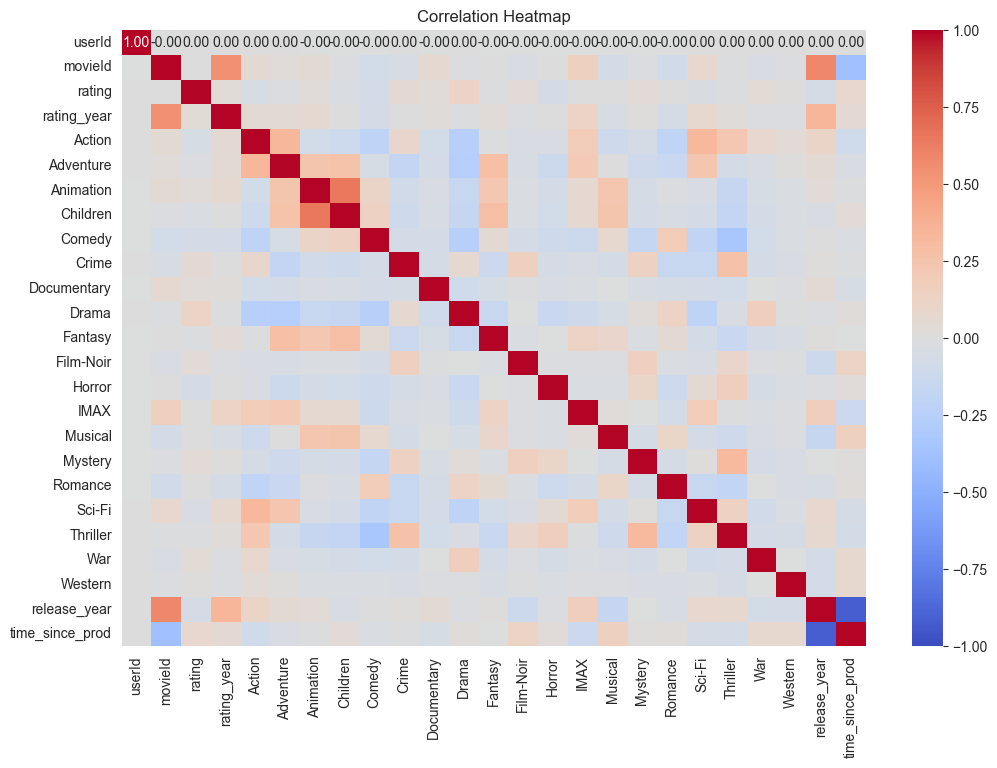

In [32]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Построена тепловая карта корреляции признаков в наборе данных.

In [33]:
num_col = data.select_dtypes(include=['int', 'float']).drop('rating', axis=1).columns

In [34]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

Функция, определяющая наиболее коррелирующие признаки в наборе данных.

In [35]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(data[num_col]))

Top Absolute Correlations
release_year  time_since_prod    0.915751
Animation     Children           0.649364
movieId       release_year       0.581790
              rating_year        0.540463
              time_since_prod    0.387747
dtype: float64


Имеется сильная корреляция между годом выпуска фильма и временем с момента его производства. Также присутствует значительная связь между жанрами фильмов "Анимация" и "Детский". Отмечается средняя корреляция между идентификатором фильма и годом его выпуска, а также между идентификатором и годом проставления оценки и небольшая корреляция между идентификатором фильма разницей во времени между годом выпуска фильма и годом проставления оценки.

Text(0.5, 1.0, 'Rating Distribution')

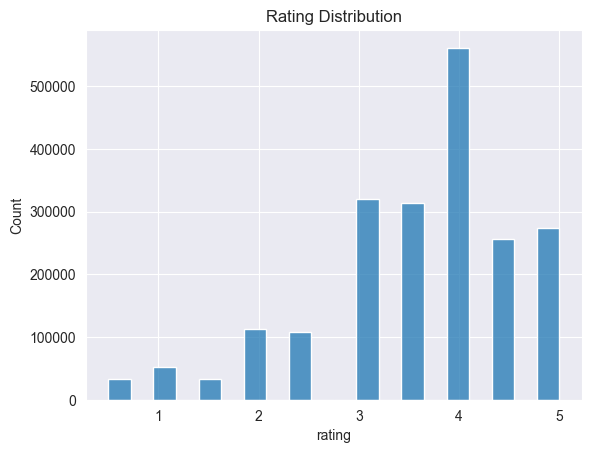

In [36]:
sns.histplot(data['rating'], bins=20)
plt.title("Rating Distribution")

Распределение целевой переменной характеризуется наличием хвоста у низких значений, а также наибольшее количество оценок сосредоточено вокруг значения "4.0", которое является модой.

<Axes: >

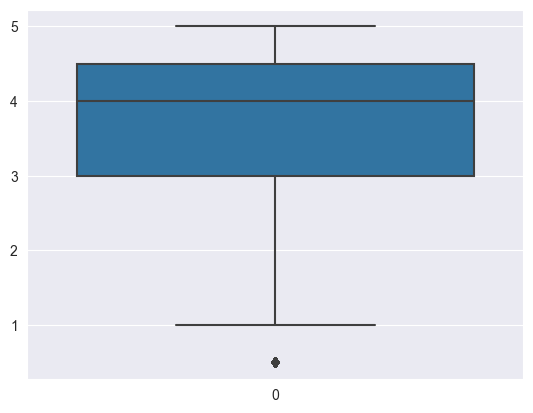

In [37]:
sns.boxplot(data['rating'])

In [38]:
len(data[data['rating'] < 0.5])

0

График показывает, что в данных имеются незначительные выбросы в значениях целевой переменной, меньших единицы, но учитывая, что рейтинги могут начинаться с "0.5", а оценок, меньших этого значения, нет, эти данные являются значимыми и не подлежат исключению как выбросы.  Большая часть оценок сосредоточена в интервале от "3.0" до "4.5", что соответствует медианному значению рейтинга 4.

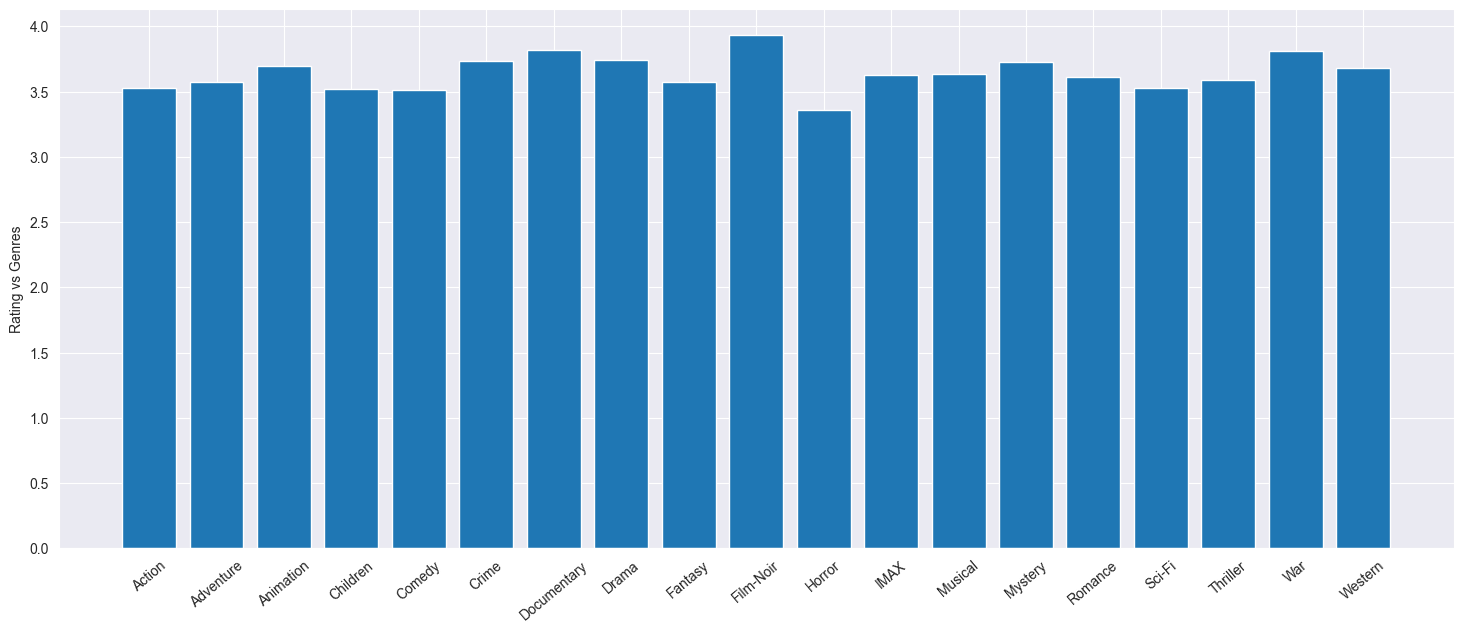

In [39]:
gnr_cols = df_genres.drop('(no genres listed)', axis=1).columns

rat_genres = []

for gnr in gnr_cols:
    rat_mean = data.groupby(gnr)['rating'].mean()[1]
    rat_genres.append(rat_mean)

fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.bar(gnr_cols, rat_genres)
ax.set_ylabel('Rating vs Genres')
plt.xticks(rotation=40)

plt.show()

В основном, оценки фильмов в различных жанрах распределены более менее равномерно, за исключением жанра "Хоррор", где средняя оценка ниже. Это может указывать на то, что фильмы жанра "Хоррор" менее привлекательны для большинства зрителей, что может отражаться в их низком рейтинге.

Text(0.5, 1.0, 'Rating vs Year')

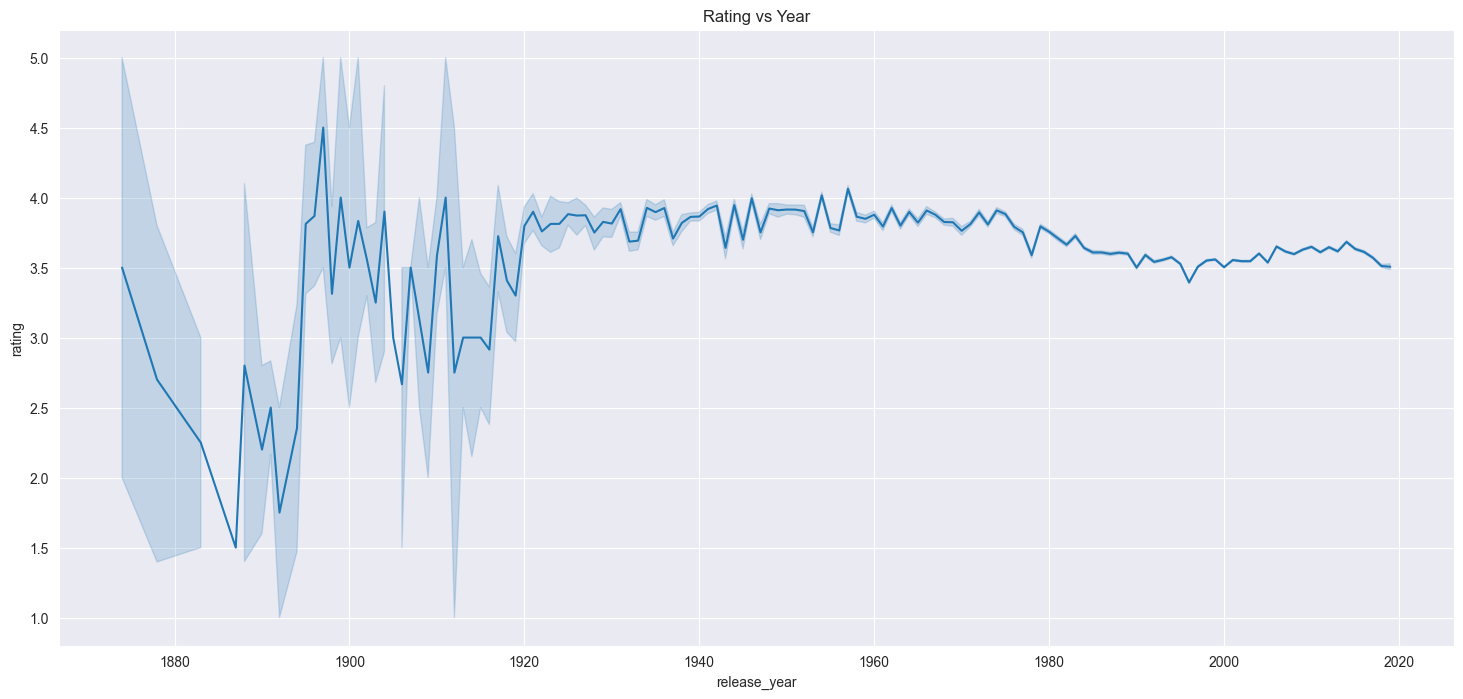

In [40]:
plt.figure(figsize=(18, 8))
sns.lineplot(data, x='release_year', y='rating')
plt.title('Rating vs Year')


Оценки фильмов, начиная с 1880 года, колеблются, но становятся более стабильными к 1920 году, после чего остаются относительно постоянными до 2019 года, с небольшим снижением.

In [41]:
len(data[(data['release_year'] <= 1920) & (data['release_year'] >= 1880)]), len(data[(data['release_year'] > 1920) & (data['release_year'] <= 1961)]) 

(579, 82378)

Период с 1880 по 1920 год характеризуется значительно меньшим количеством данных, что приводит к скачкам на графике из-за ограниченности информации. С 1920 года(следующие 40 лет) и далее, с увеличением объема данных, наблюдается более стабильное распределение оценок.

Text(0.5, 1.0, 'Rating vs Time since prod')

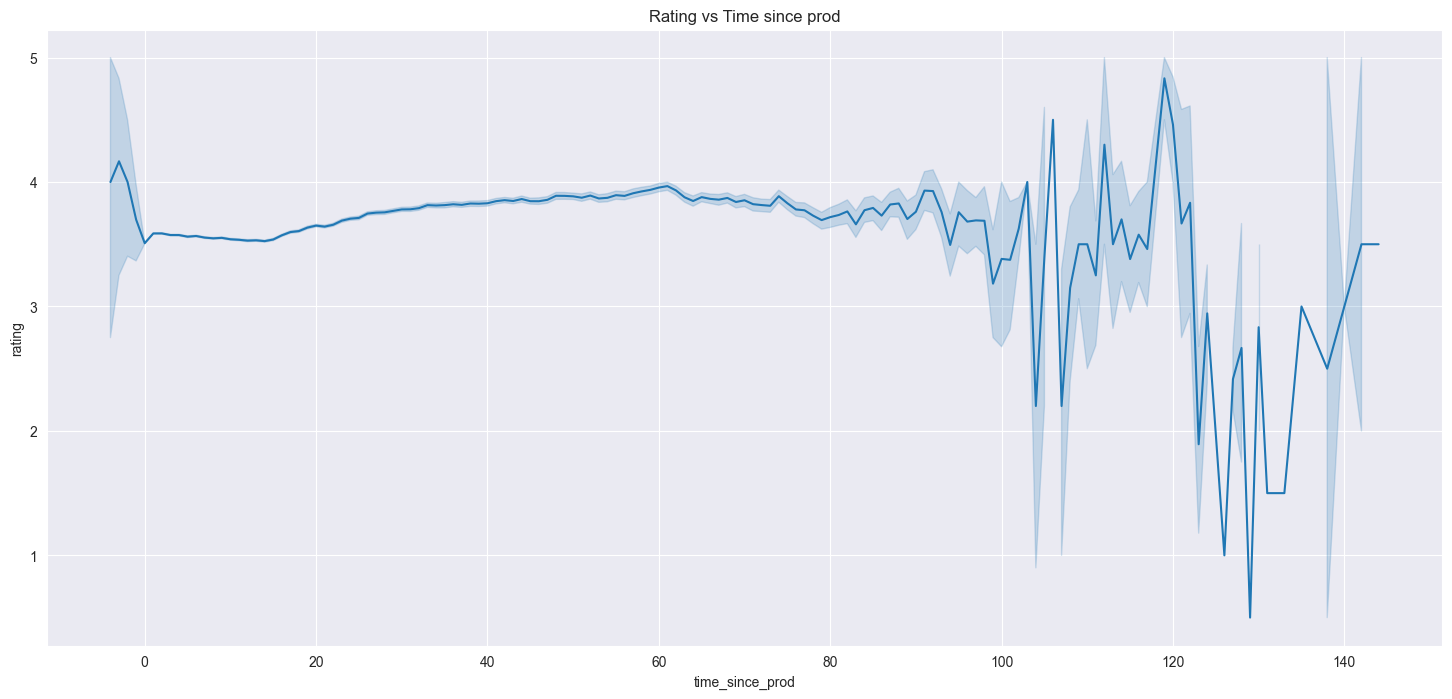

In [42]:
plt.figure(figsize=(18, 8))
sns.lineplot(data, x='time_since_prod', y='rating')
plt.title('Rating vs Time since prod')

In [43]:
len(data[(data['time_since_prod'] <= 120) & (data['time_since_prod'] >= 80)]), len(data[(data['time_since_prod'] > 40) & (data['time_since_prod'] < 80)]) 

(4848, 120588)

График распределения оценок в зависимости от времени, прошедшего с момента выхода фильма до проставления оценки пользователем, демонстрирует стабильные оценки с небольшим спадом к разнице в 100 лет. Колебания после 90-х годов снова связаны с недостатком информации в этом периоде.

#### 4. Разделение данных на тестовую и обучающую выборку

In [44]:
def split_train_test_by_user(df):
    
    def split_user_data(group):
        sorted_group = group.sort_values(by='timestamp', ascending=True)
        threshold_index = int(0.75 * len(sorted_group))
        train_data = sorted_group.iloc[:threshold_index]
        test_data = sorted_group.iloc[threshold_index:]
        return train_data, test_data
    
    train_test_data = df.groupby('userId').apply(split_user_data)
    
    train_data = pd.concat([train_test[0] for train_test in train_test_data])
    test_data = pd.concat([train_test[1] for train_test in train_test_data])
    
    return train_data, test_data

In [45]:
train_data, test_data = split_train_test_by_user(data)

In [46]:
train_data.shape, test_data.shape

((1529749, 27), (533154, 27))

Данные разделены на обучающую и тестовую выборки в приблизительном соотношении 75:25 для каждого пользователя.

In [47]:
test_data = test_data.drop(['title', 'timestamp'], axis=1)
train_data = train_data.drop(['title', 'timestamp'], axis=1)

In [48]:
train_data

,userId,movieId,rating,rating_year,Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,time_since_prod
14,1,8729,3.5,2006,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1984.0,22.0
13,1,5912,3.0,2006,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1981.0,25.0
12,1,5767,5.0,2006,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1981.0,25.0
11,1,665,5.0,2006,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1995.0,11.0
10,1,2573,4.0,2006,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1998.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065722,162541,593,4.0,2009,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1991.0,18.0
2065721,162541,2324,4.5,2009,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1997.0,12.0
2065720,162541,2788,4.5,2009,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1971.0,38.0
2065719,162541,47,4.5,2009,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1995.0,14.0


Были удалены признаки "timestamp" и "title", поскольку они не играют существенной роли в данной задаче. Название фильма и время проставления оценки не оказывают существенного влияния на выбор пользователя или составление рекомендаций, а зависят скорее от других характеристик фильмов и пользователей

Убедимся, что в тестовой выборке отсутствуют новые идентификаторы пользователей, поскольку мы строим рекомендации на основе данных о пользователях, уже присутствующих в нашей системе:

In [49]:
train_users_set = set(train_data['userId'])
test_users_set = set(test_data['userId'])

if test_users_set.issubset(train_users_set):
    print("В тестовой выборке содержатся те же айди пользователей, что и в обучающей выборке, и не появилось новых.")
else:
    print("Есть новые айди пользователей в тестовой выборке.")

В тестовой выборке содержатся те же айди пользователей, что и в обучающей выборке, и не появилось новых.


In [50]:
X_train, X_test = train_data.drop('rating', axis=1), test_data.drop('rating', axis=1)
y_train, y_test = train_data['rating'], test_data['rating']

Получены матрицы признаков для обучающей и тестовой выборок, а также векторы целевых переменных.

<Axes: xlabel='rating', ylabel='Count'>

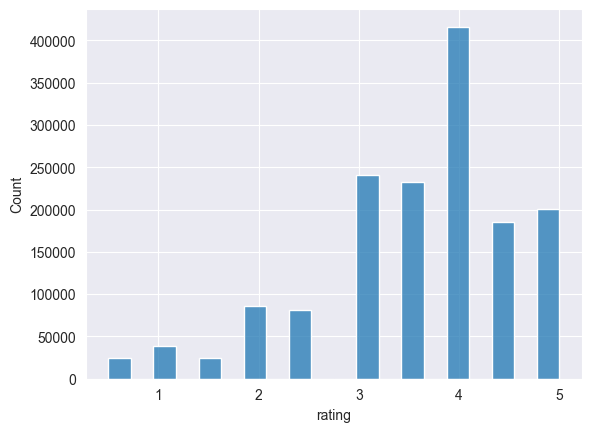

In [51]:
sns.histplot(y_train, bins=20)

<Axes: xlabel='rating', ylabel='Count'>

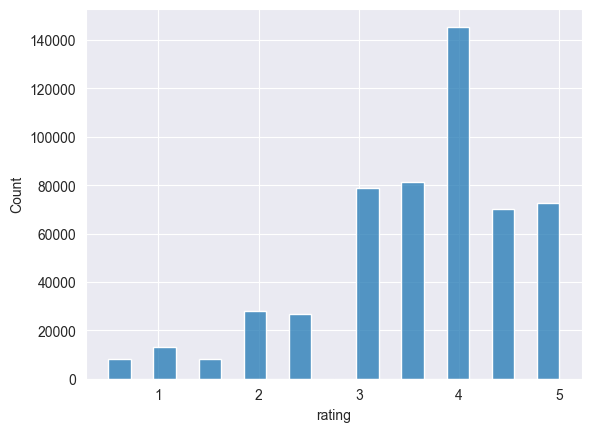

In [52]:
sns.histplot(y_test, bins=20)

Распределение данных в обучающей и тестовой выборках идентично, с модальным значением около "4.0" и хвостом у низких оценок. Размах составляет 4.5. Распределения соответствуют общему распределению данных.

#### 5. Обучения моделей

In [53]:
def predictions(X, y, model, top=5):
    mov_id = X['movieId']
    us_id = X['userId']
    res = model.predict(X)
    
    predictions = pd.DataFrame({
        'userId': us_id,
        'movieId': mov_id,
        'recommendation': res,
        'real_rating': y
    }).sort_values(by='userId')
    
    def sorted(group):
        group = group.nlargest(top, 'recommendation')
        return group
    
    predictions_df_group = predictions.groupby('userId').apply(sorted)
    predictions_df_group = predictions_df_group.reset_index(drop=True)
    
    return predictions_df_group

Функция генерирует топ-5 рекомендаций для каждого пользователя на основе предсказаний модели.

**DCG@k**

В качестве метрики ранжирования выбрана DCG@k. 

$$
dcg = \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{k} \frac{{\text{rating}_{ij}}}{{\log_2(j + 1)}}
$$

DCG@k (Discounted Cumulative Gain at k) - метрика, которая оценивает качество ранжирования результатов поиска или рекомендаций, учитывая порядок выдачи и оценки рекомендаций. Она отражает значимость элементов на основе их позиции и оценки. В данном проекте выбрана эта метрика, так как она особенно полезна при оценке систем рекомендаций, где важен не только факт рекомендации подходящих элементов, но и их порядок. Чем выше значение DCG@k, тем лучше модель рекомендаций работает.

In [54]:
def dcg_at_k(preds_df):
    dcg_val = []
    
    def penalty_score(position):
        return 1 / np.log2(position + 2) 
    
    def dcg_user(ratings):
        ratings = ratings
        dcg = np.sum(ratings * penalty_score(np.arange(len(ratings))))
        return dcg
    
    for user_id, group in preds_df.groupby('userId'):
        dcg = dcg_user(group['real_rating']) 
        dcg_val.append(dcg)
        
    return np.mean(dcg_val)

В функции реализована метрика DCG@k, которая оценивает качество рекомендаций для каждого пользователя на основе предсказанных результатов.

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [56]:
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [57]:
print(f'RMSE in Train: {mean_squared_error(y_train, rf.predict(X_train)) ** 0.5}')
print(f'RMSE in Test: {mean_squared_error(y_test, rf.predict(X_test)) ** 0.5}')

RMSE in Train: 0.3915477401570803
RMSE in Test: 1.0422955829814662


Результаты RMSE для модели случайного леса указывают на то, что она демонстрирует низкую среднеквадратическую ошибку на обучающей (0.392) и более высокую на тестовой выборке (1.042). Это свидетельствует о хорошем качестве предсказаний модели на обучающей выборке, однако на тестовых данных наблюдается увеличение ошибки, что указывает на переобучение модели. 
Кроме того, обучение модели случайного леса на 50 деревьях занимает слишком много времени. Выбор 50 деревьев для модели случайного леса обусловлен тем, чтобы провести сравнение качества моделей в более или менее одинаковых условиях.

In [58]:
print(f'DCG@k in Train: {dcg_at_k(predictions(X_train, y_train, rf))}')
print(f'DCG@k in Test: {dcg_at_k(predictions(X_test, y_test, rf))}')

DCG@k in Train: 13.012559585798114
DCG@k in Test: 10.00976054561931


DCG@k для модели случайного леса на обучающей выборке составляет 13.013, что указывает на успешное ранжирование элементов. Однако на тестовой выборке значение метрики немного ниже (10.01), что может сигнализировать о снижении эффективности модели на новых данных.

Text(0.5, 1.0, 'Prediction Rating Distribution')

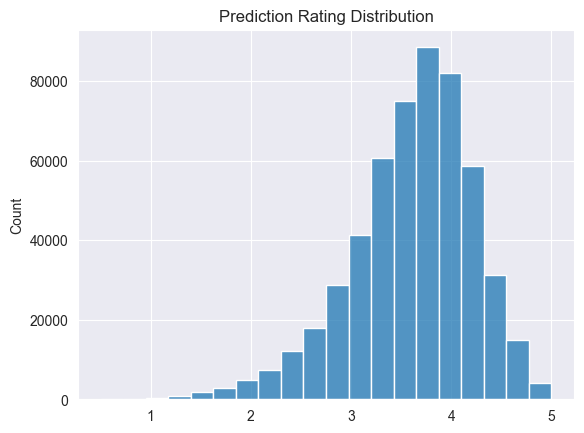

In [59]:
sns.histplot(rf.predict(X_test), bins=20)
plt.title("Prediction Rating Distribution")

Распределение предсказанных оценок напоминает распределению в исходных данных: присутствует схожий хвост у низких значений, а мода сосредоточена в центре и близка к значению "4.0". Размах составляет практически 4.

In [60]:
from catboost import CatBoostRegressor

In [87]:
catboost_default = CatBoostRegressor(random_state=42, iterations=50)
catboost_default.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 1.0141845	total: 286ms	remaining: 14s
1:	learn: 1.0076780	total: 443ms	remaining: 10.6s
2:	learn: 1.0035768	total: 647ms	remaining: 10.1s
3:	learn: 1.0013611	total: 848ms	remaining: 9.75s
4:	learn: 0.9996740	total: 1.05s	remaining: 9.48s
5:	learn: 0.9982155	total: 1.23s	remaining: 9.02s
6:	learn: 0.9973816	total: 1.43s	remaining: 8.77s
7:	learn: 0.9965725	total: 1.6s	remaining: 8.41s
8:	learn: 0.9957915	total: 1.8s	remaining: 8.22s
9:	learn: 0.9950653	total: 1.98s	remaining: 7.92s
10:	learn: 0.9945120	total: 2.18s	remaining: 7.74s
11:	learn: 0.9941235	total: 2.38s	remaining: 7.55s
12:	learn: 0.9937034	total: 2.6s	remaining: 7.4s
13:	learn: 0.9926297	total: 2.8s	remaining: 7.2s
14:	learn: 0.9923063	total: 3.02s	remaining: 7.04s
15:	learn: 0.9913884	total: 3.19s	remaining: 6.79s
16:	learn: 0.9908075	total: 3.4s	remaining: 6.6s
17:	learn: 0.9900552	total: 3.57s	remaining: 6.35s
18:	learn: 0.9898938	total: 3.75s	remaining: 6.11s
19:	learn: 0.9894039	total

In [88]:
print(f'RMSE in Train: {mean_squared_error(y_train, catboost_default.predict(X_train)) ** 0.5}')
print(f'RMSE in Test: {mean_squared_error(y_test, catboost_default.predict(X_test)) ** 0.5}')

RMSE in Train: 0.9800999521770806
RMSE in Test: 0.9822621030181882


Модель Catboost демонстрирует низкую среднеквадратическую ошибку как на обучающей (0.98), так и на тестовой выборке (0.982), подтверждая ее способность предсказывать целевую переменную с высокой точностью и хорошее обобщение данных. На тестовых данных Catboost превосходит качество модели Случайного леса, несмотря на более низкую точность на обучающей выборке.

In [89]:
print(f'DCG@k in Train: {dcg_at_k(predictions(X_train, y_train, catboost_default))}')
print(f'DCG@k in Test: {dcg_at_k(predictions(X_test, y_test, catboost_default))}')

DCG@k in Train: 11.287267057437857
DCG@k in Test: 10.040925799335367


Результаты метрики DCG@k для модели Catboost показывают, что она успешно ранжирует элементы как на обучающей (11.29), так и на тестовой выборке (10.04). Это указывает на хорошее качество ранжирования выдачи модели, как на обучающих, так и на новых, тестовых данных.

Text(0.5, 1.0, 'Prediction Rating Distribution')

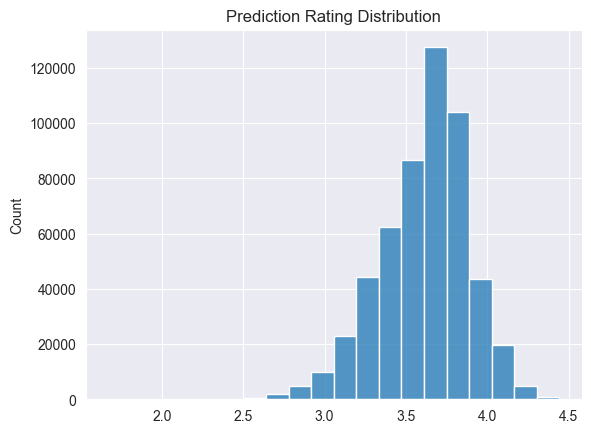

In [90]:
sns.histplot(catboost_default.predict(X_test), bins=20)
plt.title("Prediction Rating Distribution")

Предсказанные оценки модели Catboost не точно соответствуют реальному распределению оценок. В отличие от реальных данных, где мода распределения находится около 4, у Catboost мода распределения смещена ближе к 3.5. Размах значений также существенно меньше (практически 2 по сравнению с 4.5). Более того, наблюдается отсутствие хвоста у низких значений и начинается только с 2.5.

In [65]:
from lightgbm import LGBMRegressor

In [66]:
lgbm = LGBMRegressor(n_estimators=50)

lgbm.fit(X_train, y_train)

LGBMRegressor(n_estimators=50, objective='regression')

In [67]:
print(f'RMSE in Train: {mean_squared_error(y_train, lgbm.predict(X_train)) ** 0.5}')
print(f'RMSE in Test: {mean_squared_error(y_test, lgbm.predict(X_test)) ** 0.5}')

RMSE in Train: 0.9838281209517767
RMSE in Test: 0.9852970680399176


Результаты RMSE для модели LGBM показывают, что она демонстрирует сопоставимый уровень ошибки как на обучающей, так и на тестовой выборке. Однако, стоит отметить, что ошибка на тренировочных данных стала выше по сравнению с Catboost и Случайным лесом(0.984 по сравнению с 0.98 и с 0.39), а на тестовых данных модель LGBM также показывает себя хуже, чем Catboost.

In [68]:
print(f'DCG@k in Train: {dcg_at_k(predictions(X_train, y_train, lgbm))}')
print(f'DCG@k in Test: {dcg_at_k(predictions(X_test, y_test, lgbm))}')

DCG@k in Train: 11.26549177131574
DCG@k in Test: 10.025774020116446


Метрика DCG@k для модели LGBM демонстрирует хорошее ранжирование как на обучающей (11.27), так и на тестовой выборке (10.025), но значения оказываются ниже, чем у модели Catboost.

Text(0.5, 1.0, 'Prediction Rating Distribution')

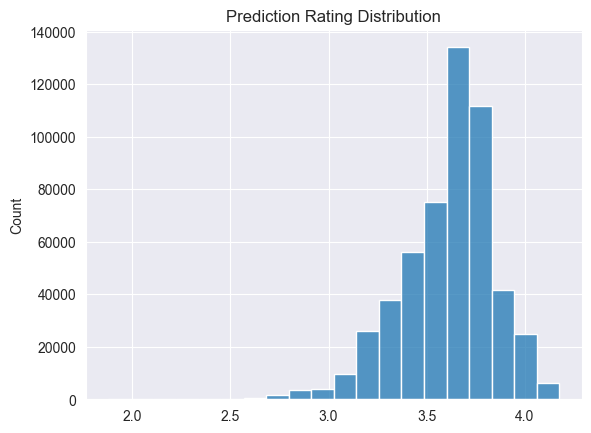

In [69]:
sns.histplot(lgbm.predict(X_test), bins=20)
plt.title("Prediction Rating Distribution")

Распределение оценок LGBM несколько уступает другим моделям, так как его размах составляет всего 1.2, что даже меньше, чем у модели Catboost. Кроме того, отсутствует хвост в низких значениях (от 1.0 до 2.5), который присутствует в реальном распределении оценок.

In [70]:
from xgboost import XGBRegressor

In [80]:
xgboost = XGBRegressor(random_state=42, n_estimators=50)
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [83]:
print(f'RMSE in Train: {mean_squared_error(y_train, xgboost.predict(X_train)) ** 0.5}')
print(f'RMSE in Test: {mean_squared_error(y_test, xgboost.predict(X_test)) ** 0.5}')

RMSE in Train: 0.9690613850877203
RMSE in Test: 0.9738325125435203


RMSE для модели XGBoost на обучающей и тестовой выборках составляют 0.969 и 0.974 соответственно, указывая на высокую точность модели. XGBoost также показывает улучшение по сравнению с Catboost, где RMSE для тренировочной выборки составляет 0.969 и 0.98, а для тестовой - 0.974 и 0.982 соответственно.

In [85]:
print(f'DCG@k in Train: {dcg_at_k(predictions(X_train, y_train, xgboost))}')
print(f'DCG@k in Test: {dcg_at_k(predictions(X_test, y_test, xgboost))}')

DCG@k in Train: 11.353625993993447
DCG@k in Test: 10.060978683163857


Результаты метрики DCG@k для моделей XGBoost на обучающей (11.353) и тестовой (10.06) выборках очень близки к результатам модели Catboost на обучающей (11.29) и тестовой (10.04) выборках. Это указывает на схожую эффективность ранжирования обеих моделей как на обучающих, так и на тестовых данных, XGboost все же немного превосходит Catboost в качестве предсказаний.

Text(0.5, 1.0, 'Prediction Rating Distribution')

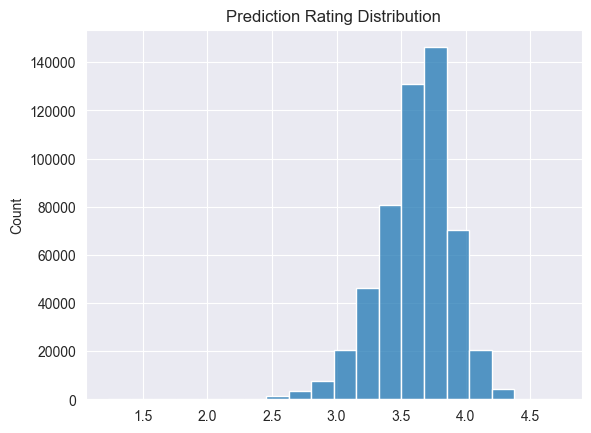

In [86]:
sns.histplot(xgboost.predict(X_test), bins=20)
plt.title("Prediction Rating Distribution")

Распределение оценок в модели XGBoost также лишено хвоста у низких значений, ограничиваясь значениями до 2.5, и размах составляет чуть менее 2. Однако, стоит отметить, что распределение оценок XGBoost более близко к моде реального распределения оценок на данных, чем у модели Catboost.

Исходя из полученных результатов, модель XGBoost демонстрирует более высокое качество прогнозирования по сравнению с остальными моделями. Несмотря на то, что время обработки немного выше, чем у некоторых других моделей, оно все равно находится в разумных пределах. Учитывая это и высокое качество прогнозов, XGBoost выбрана для дальнейшей оптимизации гиперпараметров и улучшения метрик.

#### 6. Улучшение выбранной модели

In [75]:
from sklearn.model_selection import GridSearchCV

In [93]:
xgb = XGBRegressor()

param_grid = {
    'learning_rate': [0.3, 0.1, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END colsample_bytree=0.8, learning_rate=0.3, n_estimators=100, subsample=0.6; total time= 1.7min
[CV] END colsample_bytree=0.8, learning_rate=0.3, n_estimators=100, subsample=0.6; total time= 1.6min
[CV] END colsample_bytree=0.8, learning_rate=0.3, n_estimators=100, subsample=0.6; total time= 1.6min
[CV] END colsample_bytree=0.8, learning_rate=0.3, n_estimators=100, subsample=0.8; total time= 1.5min
[CV] END colsample_bytree=0.8, learning_rate=0.3, n_estimators=100, subsample=0.8; total time= 1.5min
[CV] END colsample_bytree=0.8, learning_rate=0.3, n_estimators=100, subsample=0.8; total time= 1.5min
[CV] END colsample_bytree=0.8, learning_rate=0.3, n_estimators=100, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.8, learning_rate=0.3, n_estimators=100, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.8, learning_rate=0.3, n_estimators=100, subsample=1.0; total time= 1.3min
[CV] END colsample_b

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.3, 0.1, 0.05],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

Осуществлен поиск оптимальных параметров для модели XGBoost на тренировочных данных с помощью Grid Search и кросс-валидации. После выполнения поиска лучшая комбинация параметров будет сохранена для дальнейшего использования.

In [94]:
print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучшая оценка (RMSE): {(-grid_search.best_score_) ** 0.5}')

Лучшие параметры: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'n_estimators': 300, 'subsample': 0.8}
Лучшая оценка (RMSE): 0.9807045251391447


In [95]:
xgb_best = XGBRegressor(n_estimators=300, learning_rate=0.05, subsample=0.8, colsample_bytree=1.0, random_state=42)
xgb_best.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

Создана и обучена лучшая модель XGBoost с оптимальными параметрами, найденными через Grid Search, на тренировочных данных.

In [96]:
print(f'RMSE in Train: {mean_squared_error(y_train, xgb_best.predict(X_train)) ** 0.5}')
print(f'RMSE in Test: {mean_squared_error(y_test, xgb_best.predict(X_test)) ** 0.5}')

RMSE in Train: 0.9697098963003661
RMSE in Test: 0.9741418118442587


Полученные результаты показывают, что RMSE для лучшей модели немного хуже, чем для базовой модели на обучающей (0.9697 по сравнению с 0.969) и тестовой (0.9741 по сравнению с 0.9738) выборках. При этом, стоит отметить, что время обучения лучшей модели значительно выше, чем у базовой.

In [97]:
print(f'DCG@k in Train: {dcg_at_k(predictions(X_train, y_train, xgb_best))}')
print(f'DCG@k in Test: {dcg_at_k(predictions(X_test, y_test, xgb_best))}')

DCG@k in Train: 11.35812542224325
DCG@k in Test: 10.064742607363259


Однако, метрика ранжирования показывает лучшие результаты по сравнению со всеми остальными моделями. В контексте задачи рекомендательной системы, где метрика ранжирования играет важную роль, была выбрана модель XGBoost с оптимальными гиперпараметрами.

Text(0.5, 1.0, 'Top 15 feature importance')

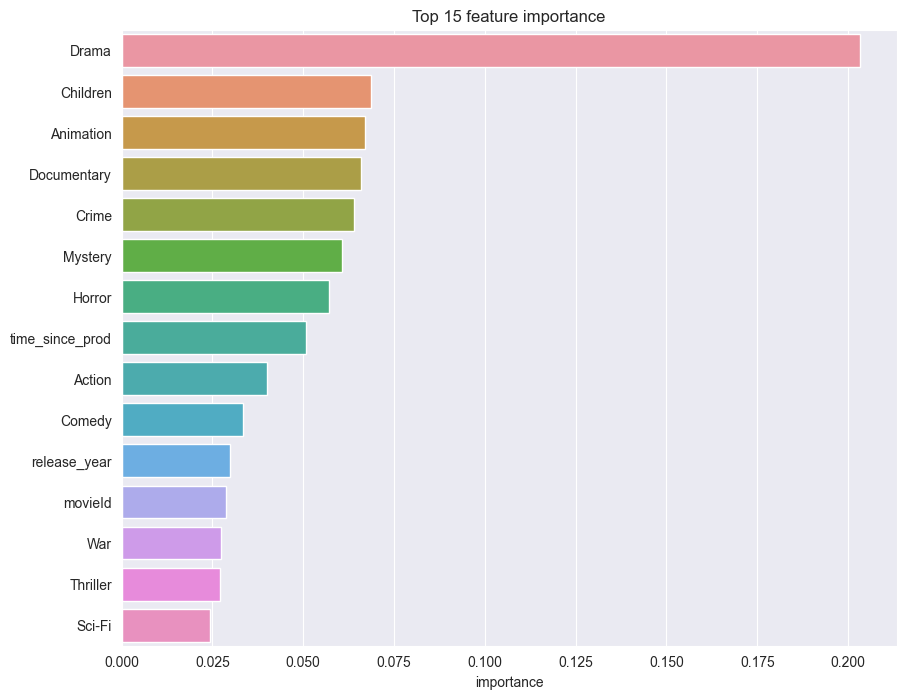

In [104]:
importances = xgb_best.feature_importances_

df_feature_importances = pd.DataFrame(
    importances,
    index=X_train.columns,
    columns=['importance']
).sort_values(by='importance', ascending=False)[:15]

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y=df_feature_importances.index, data=df_feature_importances)
plt.title('Top 15 feature importance')

Построен график горизонтальных столбцов, отображающий важность топ-15 признаков. Каждый столбец представляет собой важность признака, отсортированную по убыванию значений.

In [116]:
cols_top_15 = df_feature_importances.index.tolist() + ['userId']
X_train_top_15, X_test_top_15 = X_train[cols_top_15], X_test[cols_top_15]

xgb_best.fit(X_train_top_15, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

Созданы выборки, содержащие только топ-15 признаков, на которых обучена модель с оптимальными параметрами XGBoost. Кроме того, добавлен признак идентификатора пользователя, поскольку он необходим для вычисления метрики ранжирования DCG@k.

In [117]:
print(f'RMSE in Train: {mean_squared_error(y_train, xgb_best.predict(X_train_top_15)) ** 0.5}')
print(f'RMSE in Test: {mean_squared_error(y_test, xgb_best.predict(X_test_top_15)) ** 0.5}')

RMSE in Train: 0.9713320359538611
RMSE in Test: 0.9747347177982366


Ошибка RMSE на обучающей и тестовой выборках незначительно увеличилась, что указывает на небольшое снижение обобщающей способности модели, обученной на выборках, состоящих из топ-15 признаков.

In [118]:
print(f'DCG@k in Train: {dcg_at_k(predictions(X_train_top_15, y_train, xgb_best))}')
print(f'DCG@k in Test: {dcg_at_k(predictions(X_test_top_15, y_test, xgb_best))}')

DCG@k in Train: 11.353367502793356
DCG@k in Test: 10.06169170601159


Метрика ранжирования также демонстрирует более низкие показатели по сравнению с моделью, обученной на всех признаках.

Таким образом, лучшей моделью рекомендательной системы оказалась XGBoost, обученная на всех признаках. Эта модель была настроена с использованием следующих параметров: 
- 300 базовых моделей (деревьев) - помогает учесть множество зависимостей в данных.
- Скорость обучения (learning rate) установлена на 0.05, обеспечивая хороший баланс между скоростью и качеством модели.
- Модель использовала 80% обучающих образцов при каждой итерации, что помогает избежать переобучения.
- При обучении каждого дерева использовались все признаки, обеспечивая модели полную информацию для принятия решений.

#### 7. Сравнение модели с оптимальными параметрами и константной модели.


Дополнительно проведена проверка обобщающей способности выбранной модели в сравнении с константной моделью. В этом контексте константная модель будет предсказывать моду данных, т.е. значение "4.0".

In [119]:
class ConstantModel:
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.full(len(X), 4)

constant_model = ConstantModel()

Создан класс ConstantModel, представляющий собой простую модель, которая всегда возвращает значение 4 в качестве прогноза, независимо от входных данных.

In [120]:
print(f'RMSE in Train: {mean_squared_error(y_train, constant_model.predict(X_train)) ** 0.5}')
print(f'RMSE in Test: {mean_squared_error(y_test, constant_model.predict(X_test)) ** 0.5}')

RMSE in Train: 1.1049014159412318
RMSE in Test: 1.0885393699421355


Ошибка RMSE константной модели значительно выше в сравнении с моделью XGBoost с оптимальными параметрами.

In [121]:
print(f'DCG@k in Train: {dcg_at_k(predictions(X_train, y_train, constant_model))}')
print(f'DCG@k in Test: {dcg_at_k(predictions(X_test, y_test, constant_model))}')

DCG@k in Train: 10.653135521630864
DCG@k in Test: 9.795073814608354


Отличие в метрике ранжирования между моделью с оптимальными параметрами XGBoost и константной моделью говорит о том, что первая модель действительно лучше учитывает особенности данных и способна делать более точные рекомендации для пользователей.

#### 8. Вывод и подведение итогов.

Проект включал анализ данных о рейтингах кинофильмов и разработку рекомендательной системы на их основе. Мы исследовали временные тенденции оценок, изучили влияние различных жанров на рейтинги и сравнили модели машинного обучения для предсказания рейтингов. В результате выбрали XGBoost с оптимальными параметрами как наиболее эффективную модель. В дальнейшем возможно улучшение модели путем добавления новых признаков о каждом пользователе(например, пол и возраст), а так же большей информации о каждом фильме(например, длительность фильма и режиссер).

Этот проект - не просто техническое решение. Это исследование мировой кинематографии в цифровом формате, предлагающее каждому пользователю персонального кинокритика. Мы анализировали данные о рейтингах как отражение вкусов и настроений миллионов пользователей, а алгоритмы машинного обучения создали кинематографические путешествия для каждого. В дальнейшем, добавив больше данных о пользователях и фильмах, мы сможем сделать нашу систему еще более точной и персонализированной.

В проекте применен контентный подход в рекомендательной системе. Этот подход основан на анализе характеристик кинофильмов и благодаря этому позволяет создавать персонализированные рекомендации, учитывая интересы пользователей и характеристики фильмов.